In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th

In [2]:
phantom_data=scipy.io.loadmat('Bay1_Helmut.mat')

In [3]:
gt = phantom_data["Ground_Truth"]
fmri = phantom_data["fMRI_Output"]

In [4]:
gt_mean = np.mean(gt,axis=1)
fmri_mean = np.mean(gt,axis=1)
gt_std = np.std(gt,axis=1)
fmri_std = np.std(fmri,axis=1)

In [5]:
gt_norm = (gt - gt_mean[:,np.newaxis])/gt_std[:,np.newaxis]
fmri_norm = (fmri - fmri_mean[:,np.newaxis])/fmri_std[:,np.newaxis]

In [6]:
gt_data = gt_norm[499]
fmri_data = fmri_norm[499]

600


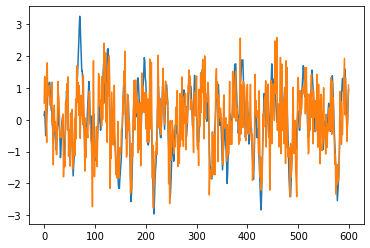

In [7]:
plt.plot(gt_data)
plt.plot(fmri_data)
print(len(gt_data))

In [41]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,5)
    ampl1 = pm.Uniform('ampl1',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data,
                              sigma=np.sqrt(sigma1**2+ampl1**2*np.abs(gt_data)**2), observed=fmri_data)

    posterior_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl1, sigma1]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 5837.77draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff39aa36eb8>,
      dtype=object)

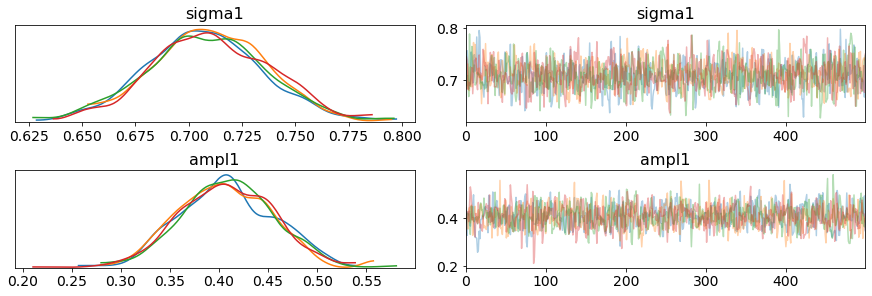

In [42]:
pm.traceplot(posterior_2)

In [44]:
pm.summary(posterior_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma1,0.709216,0.027571,0.000662,0.652218,0.760037,1366.908648,1.001487
ampl1,0.407091,0.047531,0.001160,0.319602,0.497101,1367.219876,0.999927


In [36]:
# here is a more realistic model
with pm.Model() as multi_noise2:
    sigma1 = pm.Uniform('sigma1',0,5)
    ampl1 = pm.Uniform('ampl1',0,5)
    noise_thermal = pm.Normal('noise_thermal',mu=gt_data, sigma=sigma1,shape=len(gt_data))
    noise_multi = pm.Normal('noise_multi',mu=0, sigma=ampl1*np.abs(gt_data),shape=len(gt_data))
    
    fmri = pm.Deterministic('fmri', noise_thermal + noise_multi)
    fmri_observed = pm.Normal('fmri_observed', mu=fmri, tau=10000,observed=fmri_data)

    posterior = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_multi, noise_thermal, ampl1, sigma1]
Sampling 4 chains: 100%|██████████| 12000/12000 [05:38<00:00, 35.44draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff38ae79d30>,
      dtype=object)

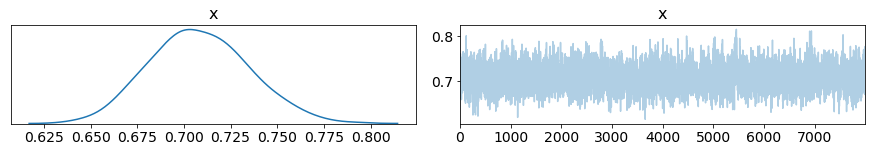

In [37]:
pm.traceplot(posterior['sigma1'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff38b389b70>,
      dtype=object)

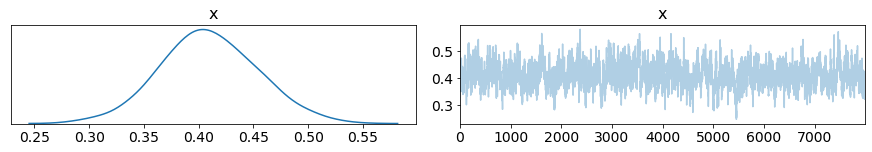

In [38]:
pm.traceplot(posterior['ampl1'])